## GEO877, Mckenzie
We use 'cleaned202007-cogo-tripdata.csv' as a sample input, and finish tasks below:

0. **Fixed station location** We extract the unique values of start_station_id, and alculate the mean start_lng and mean start_lat for each unique station, then store them as a station list, with station id, langtitude, and altitude.

Then we achieve such functions:

1. **Coordinate conversion** Convert WGS 84 (longitude and latitude) to NAD83 / California Albers projection (EPSG:3310).

2. **Hexagonal Grid** We calculate the mean trip distance of this dataset, and set it as the radius of our hexagonal grid. Then we extract the vertices of hexagons and store them as a polygon dictionary.

3. **Intersection** 
We intersect start and end station points with hexagonal gird (without effective index, not optimal) to examine the contiguity of stations.
We also intersect this hexagonal gird (without effective index, not optimal) over the administrative boundary of columbus.

source of geojson:
https://opendata.columbus.gov/datasets/41e148328e3c4c59bbc7be880c0a6737/about

source of boundary box:
OSM

### 0.Fixed start station location

In [1]:
import csv
import math

# Step 1: Read the CSV file
file_path = 'D:/UZH/Spatial Algorithms/hexagon/cleaned202007-cogo-tripdata.csv'
data = []

with open(file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        data.append(row)

# Step 2: Extract the unique values of start_station_id
unique_stations = {}
for row in data:
    station_id = row['start_station_id']
    if station_id not in unique_stations:
        unique_stations[station_id] = {'lngs': [], 'lats': []}
    unique_stations[station_id]['lngs'].append(float(row['start_lng']))
    unique_stations[station_id]['lats'].append(float(row['start_lat']))

# Step 3: Calculate the mean start_lng and mean start_lat for each unique station
station_data = {}
for station_id, coords in unique_stations.items():
    mean_lng = sum(coords['lngs']) / len(coords['lngs'])
    mean_lat = sum(coords['lats']) / len(coords['lats'])
    station_data[station_id] = {'mean_start_lng': mean_lng, 'mean_start_lat': mean_lat}

# Convert mean coordinates to NAD83 / California Albers projection (EPSG:3310)
def convert_to_albers(lon, lat):
    # Constants for the Albers equal-area projection (EPSG:3310)
    a = 6378137.0  # Semi-major axis
    e = 0.081819191  # Eccentricity
    phi0 = math.radians(37.66666666666666)  # Latitude of the origin
    phi1 = math.radians(38.73333333333333)  # First standard parallel
    phi2 = math.radians(40.03333333333333)  # Second standard parallel
    lambda0 = math.radians(-82.5)  # Central meridian
    fe = 600000.0  # False easting
    fn = 0.0  # False northing

    phi = math.radians(lat)
    lambda_ = math.radians(lon)
    
    n = (math.sin(phi1) + math.sin(phi2)) / 2
    C = math.cos(phi1)**2 + 2 * n * math.sin(phi1)
    rho0 = a * math.sqrt(C - 2 * n * math.sin(phi0)) / n
    rho = a * math.sqrt(C - 2 * n * math.sin(phi)) / n
    theta = n * (lambda_ - lambda0)
    
    x = fe + rho * math.sin(theta)
    y = fn + rho0 - rho * math.cos(theta)
    
    return x, y

# Convert the mean coordinates to the new projection
for station_id, coords in station_data.items():
    mean_lng = coords['mean_start_lng']
    mean_lat = coords['mean_start_lat']
    coords['start_x'], coords['start_y'] = convert_to_albers(mean_lng, mean_lat)

# Print the result to verify
for station_id, coords in station_data.items():
    print(f"Station ID: {station_id}, X: {coords['start_x']}, Y: {coords['start_y']}")



# Extract start_x and start_y coordinates from station_data
start_xs = [coords['start_x'] for coords in station_data.values()]
start_ys = [coords['start_y'] for coords in station_data.values()]

# Zip these lists to create a list of station points
start_station_points = list(zip(start_xs, start_ys))
print("There are", len(start_station_points), "start stations in this dataset.")

Station ID: 50.0, X: 556854.0927575239, Y: 258756.71976257954
Station ID: 75.0, X: 552961.2590527163, Y: 260673.33194784168
Station ID: 6.0, X: 557751.7340146792, Y: 253393.05717845634
Station ID: 105.0, X: 558969.2728328079, Y: 259127.1139168013
Station ID: 1.0, X: 557067.1893649272, Y: 254941.66919528414
Station ID: , X: 557860.1872208333, Y: 257161.78357722983
Station ID: 49.0, X: 557393.4972634824, Y: 258584.8512827782
Station ID: 2.0, X: 556977.183444837, Y: 255725.65688890964
Station ID: 20.0, X: 557041.5507356384, Y: 256757.29464616627
Station ID: 54.0, X: 556195.7373974773, Y: 258775.9757858105
Station ID: 4.0, X: 556555.9063358027, Y: 253831.93935211096
Station ID: 30.0, X: 558932.496566676, Y: 255747.44426909648
Station ID: 70.0, X: 562783.6789938582, Y: 254844.56230746955
Station ID: 10.0, X: 557728.3067704869, Y: 254221.14371476788
Station ID: 19.0, X: 556782.881363944, Y: 255534.73743720353
Station ID: 94.0, X: 553758.6597355691, Y: 259155.8399370797
Station ID: 18.0, X: 5

### 1. Coordinate conversion

In [2]:
import csv
import math
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
file_path = 'D:/UZH/Spatial Algorithms/hexagon/cleaned202007-cogo-tripdata.csv'
data = []

with open(file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        data.append(row)

# Step 2: Convert longitude and latitude to NAD83 / California Albers projection (EPSG:3310)
def convert_to_albers(lon, lat):
    # Constants for the Albers equal-area projection (EPSG:3310)
    a = 6378137.0  # Semi-major axis
    e = 0.081819191  # Eccentricity
    phi0 = math.radians(37.66666666666666)  # Latitude of the origin
    phi1 = math.radians(38.73333333333333)  # First standard parallel
    phi2 = math.radians(40.03333333333333)  # Second standard parallel
    lambda0 = math.radians(-82.5)  # Central meridian
    fe = 600000.0  # False easting
    fn = 0.0  # False northing

    phi = math.radians(lat)
    lambda_ = math.radians(lon)
    
    n = (math.sin(phi1) + math.sin(phi2)) / 2
    C = math.cos(phi1)**2 + 2 * n * math.sin(phi1)
    rho0 = a * math.sqrt(C - 2 * n * math.sin(phi0)) / n
    rho = a * math.sqrt(C - 2 * n * math.sin(phi)) / n
    theta = n * (lambda_ - lambda0)
    
    x = fe + rho * math.sin(theta)
    y = fn + rho0 - rho * math.cos(theta)
    
    return x, y

for row in data:
    row['start_x'], row['start_y'] = convert_to_albers(float(row['start_lng']), float(row['start_lat']))
    row['end_x'], row['end_y'] = convert_to_albers(float(row['end_lng']), float(row['end_lat']))

# Step 3: Define the bounding box based on the provided coordinates
bbox_lon_lat = (-83.2101797, 39.8086936, -82.7713119, 40.1573082)
min_x, min_y = convert_to_albers(bbox_lon_lat[0], bbox_lon_lat[1])
max_x, max_y = convert_to_albers(bbox_lon_lat[2], bbox_lon_lat[3])
bbox = (min_x, min_y, max_x, max_y)

### 2. Hexagonal Grid

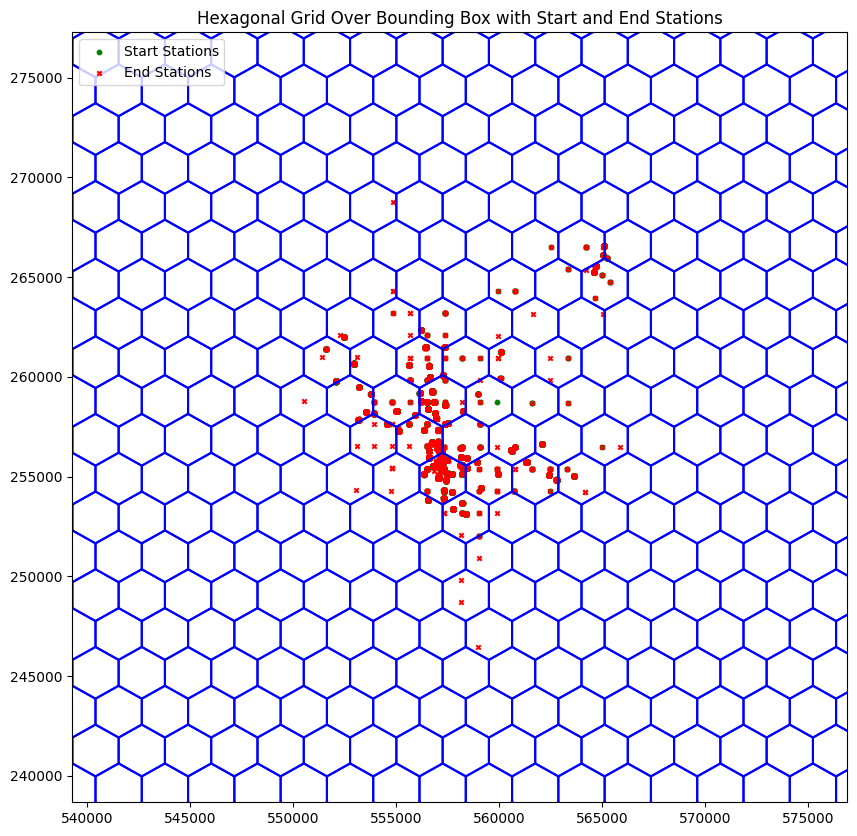

{'hexagon_id': 0, 'polygon': [(537024.2112312281, 236727.76617331847), (537024.2112312281, 238025.80685061478), (538148.3474329122, 238674.82718926296), (539272.4836345965, 238025.80685061478), (539272.4836345965, 236727.76617331847), (538148.3474329122, 236078.7458346703), (537024.2112312281, 236727.76617331847)]}
{'hexagon_id': 1, 'polygon': [(539272.4836345965, 236727.76617331847), (539272.4836345965, 238025.80685061478), (540396.6198362806, 238674.82718926296), (541520.7560379648, 238025.80685061478), (541520.7560379648, 236727.76617331847), (540396.6198362806, 236078.7458346703), (539272.4836345965, 236727.76617331847)]}
{'hexagon_id': 2, 'polygon': [(541520.7560379648, 236727.76617331847), (541520.7560379648, 238025.80685061478), (542644.892239649, 238674.82718926296), (543769.0284413332, 238025.80685061478), (543769.0284413332, 236727.76617331847), (542644.892239649, 236078.7458346703), (541520.7560379648, 236727.76617331847)]}
{'hexagon_id': 3, 'polygon': [(543769.0284413332, 2

In [3]:
# Step 4: Calculate the mean distance of each trip
def calculate_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

distances = [calculate_distance(row['start_x'], row['start_y'], row['end_x'], row['end_y']) for row in data]
mean_distance = sum(distances) / len(distances)

# Step 5: Create hexagonal grid over the bounding box
def calculate_polygons(startx, starty, endx, endy, radius):
    sl = (2 * radius) * math.tan(math.pi / 6)
    p = sl * 0.5
    b = sl * math.cos(math.radians(30))
    w = b * 2
    h = 2 * sl

    startx = startx - w
    starty = starty - h
    endx = endx + w
    endy = endy + h

    origx = startx
    origy = starty

    xoffset = b
    yoffset = 3 * p

    polygons = []
    row = 1

    while starty < endy:
        if row % 2 == 0:
            startx = origx + xoffset
        else:
            startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty + p
            p2x = startx
            p2y = starty + (3 * p)
            p3x = startx + b
            p3y = starty + h
            p4x = startx + w
            p4y = starty + (3 * p)
            p5x = startx + w
            p5y = starty + p
            p6x = startx + b
            p6y = starty
            poly = [
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p5x, p5y),
                (p6x, p6y),
                (p1x, p1y)] # close polygons
            polygons.append(poly)
            startx += w
        starty += yoffset
        row += 1
    return polygons

hexagons = calculate_polygons(min_x, min_y, max_x, max_y, mean_distance)

# Step 6: Plot the hexagon grid and points of start and end stations
plt.figure(figsize=(10, 10))
for hexagon in hexagons:
    xs, ys = zip(*hexagon)
    plt.plot(xs, ys, 'b-')

# Plot start and end points
start_xs = [row['start_x'] for row in data]
start_ys = [row['start_y'] for row in data]
end_xs = [row['end_x'] for row in data]
end_ys = [row['end_y'] for row in data]

plt.scatter(start_xs, start_ys, color='green', marker='o', label='Start Stations', s=10)
plt.scatter(end_xs, end_ys, color='red', marker='x', label='End Stations', s=10)

plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Hexagonal Grid Over Bounding Box with Start and End Stations')
plt.legend()
plt.show()
# Step 6: Store hexagons in a list of dictionaries
hexagon_data = []

for i, hexagon in enumerate(hexagons):
    hexagon_data.append({
        'hexagon_id': i,
        'polygon': hexagon
    })

# Display the first few hexagons
for hexagon in hexagon_data[:5]:
    print(hexagon)

print("There are", len(hexagon_data), "hexagon units in Columbus bbox.")

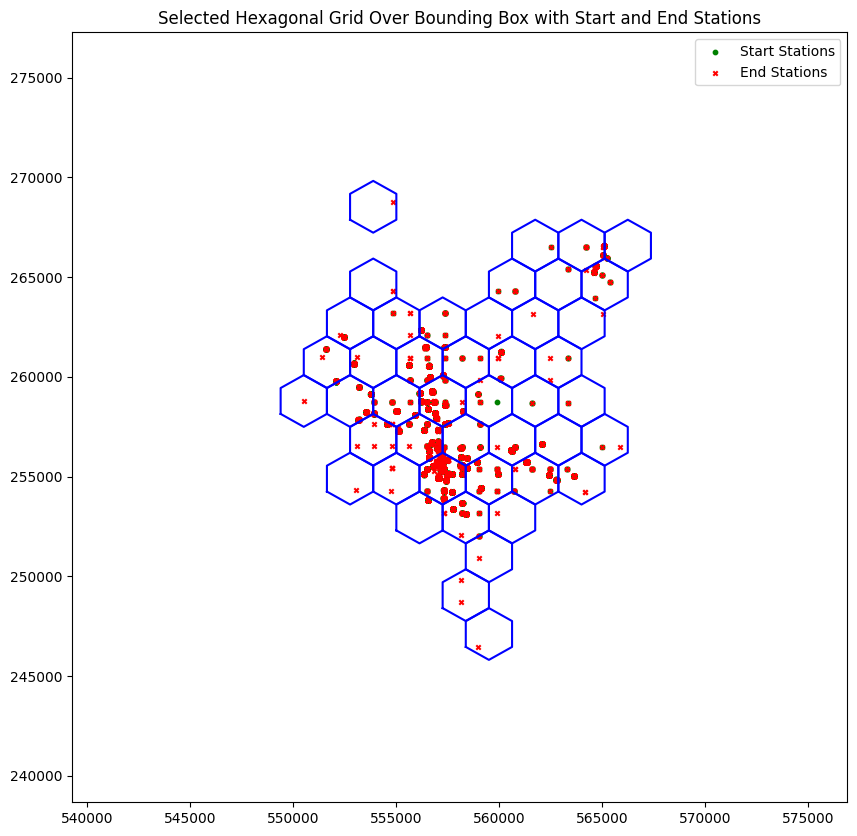

In [18]:
# Step 6: Check if a point is inside a hexagon
def is_point_in_hexagon(point, hexagon):
    x, y = point
    n = len(hexagon)
    inside = False
    p1x, p1y = hexagon[0]
    for i in range(n + 1):
        p2x, p2y = hexagon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# Step 7: Select hexagons containing start or end points
selected_hexagons = []
for hexagon in hexagons:
    for row in data:
        if is_point_in_hexagon((row['start_x'], row['start_y']), hexagon) or is_point_in_hexagon((row['end_x'], row['end_y']), hexagon):
            selected_hexagons.append(hexagon)
            break

# Step 8: Plot the selected hexagon grid and points of start and end stations
plt.figure(figsize=(10, 10))
for hexagon in selected_hexagons:
    xs, ys = zip(*hexagon)
    plt.plot(xs, ys, 'b-')

# Plot start and end points
start_xs = [row['start_x'] for row in data]
start_ys = [row['start_y'] for row in data]
end_xs = [row['end_x'] for row in data]
end_ys = [row['end_y'] for row in data]

plt.scatter(start_xs, start_ys, color='green', marker='o', label='Start Stations', s=10)
plt.scatter(end_xs, end_ys, color='red', marker='x', label='End Stations', s=10)

plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)
plt.title('Selected Hexagonal Grid Over Bounding Box with Start and End Stations')
plt.legend()
plt.show()

In [22]:

points = list(zip(start_xs, start_ys))

print(points)

[(556852.3705464279, 258756.34304855857), (552957.1951169058, 260679.71873811353), (557756.5625603514, 253386.32443876565), (558972.4174842108, 259127.74241863843), (557058.6877633793, 254948.7769507002), (557350.3288248092, 257624.31674177665), (556503.6311580719, 258742.2742822813), (552957.7626119651, 260674.90986537188), (557389.3588609307, 258606.81637355033), (557338.0017745246, 255397.93427829817), (556979.4151248531, 255743.39578821044), (557038.7842538866, 256758.15972272865), (559897.6978184223, 255384.18691960815), (556198.1992722575, 258770.0546787493), (557350.3288248092, 257624.31674177665), (556558.8792711964, 253828.96047235746), (558928.8378582693, 255746.7286015926), (562768.9188492032, 254858.62312609795), (557730.4771212792, 254224.4511972256), (558936.1495448943, 255747.1905809557), (556790.2296346447, 255528.17292096466), (557350.3288248092, 257624.31674177665), (553758.213223001, 259155.22558776103), (556785.1981170789, 255526.10456073005), (557338.0017745246, 25

In [39]:
# Step 6: Store hexagons in a list of dictionaries
hexagon_selected_data = []

for i, hexagon in enumerate(selected_hexagons):
    hexagon_selected_data.append({
        'hexagon_id': i,
        'polygon': hexagon
    })

# Display the first few hexagons
for hexagon in hexagon_selected_data[:5]:
    print(hexagon)
    
print("There are", len(hexagon_selected_data), "hexagon units containing bike stations in Columbus bbox.")

{'hexagon_id': 0, 'polygon': [(558382.7990632276, 246463.07125304092), (558382.7990632276, 247761.11193033724), (559506.9352649117, 248410.1322689854), (560631.071466596, 247761.11193033724), (560631.071466596, 246463.07125304092), (559506.9352649117, 245814.05091439275), (558382.7990632276, 246463.07125304092)]}
{'hexagon_id': 1, 'polygon': [(557258.6628615435, 248410.1322689854), (557258.6628615435, 249708.17294628173), (558382.7990632276, 250357.1932849299), (559506.9352649119, 249708.17294628173), (559506.9352649119, 248410.1322689854), (558382.7990632276, 247761.11193033724), (557258.6628615435, 248410.1322689854)]}
{'hexagon_id': 2, 'polygon': [(558382.7990632276, 250357.1932849299), (558382.7990632276, 251655.23396222622), (559506.9352649117, 252304.2543008744), (560631.071466596, 251655.23396222622), (560631.071466596, 250357.1932849299), (559506.9352649117, 249708.17294628173), (558382.7990632276, 250357.1932849299)]}
{'hexagon_id': 3, 'polygon': [(555010.3904581751, 252304.25

### 3. Intersection

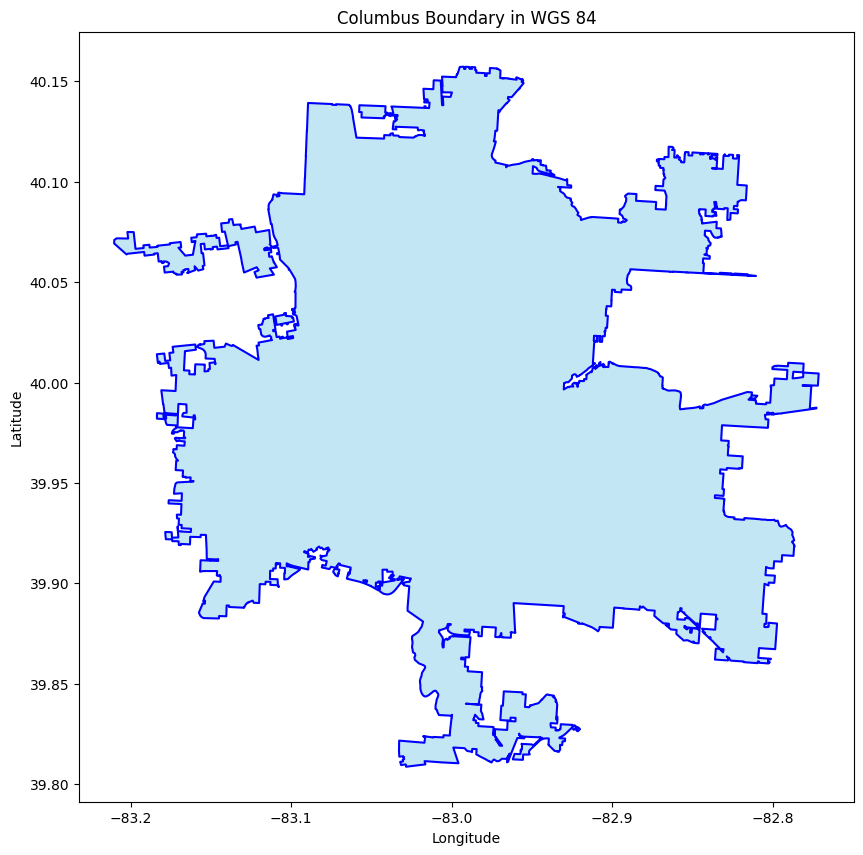

In [7]:
import json
import matplotlib.pyplot as plt
# Step 1: Read the GeoJSON file
geojson_file_path = 'D:/UZH/Spatial Algorithms/hexagon/Corporate_Boundary.geojson'

with open(geojson_file_path, 'r') as f:
    geojson_data = json.load(f)

# Step 2: Extract the single polygon coordinates from the GeoJSON data
# GeoJSON file contains a single Polygon
polygon = []

for feature in geojson_data['features']:
    if feature['geometry']['type'] == 'Polygon':
        polygon = feature['geometry']['coordinates'][0]  # Assuming it's a single polygon
        break
    elif feature['geometry']['type'] == 'MultiPolygon':
        polygon = feature['geometry']['coordinates'][0][0]  # First polygon of the first multipolygon
        break

# Step 3: Plot the polygon
plt.figure(figsize=(10, 10))
xs, ys = zip(*polygon)
plt.plot(xs, ys, 'b-')
plt.fill(xs, ys, 'skyblue', alpha=0.5)
plt.title('Columbus Boundary in WGS 84')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

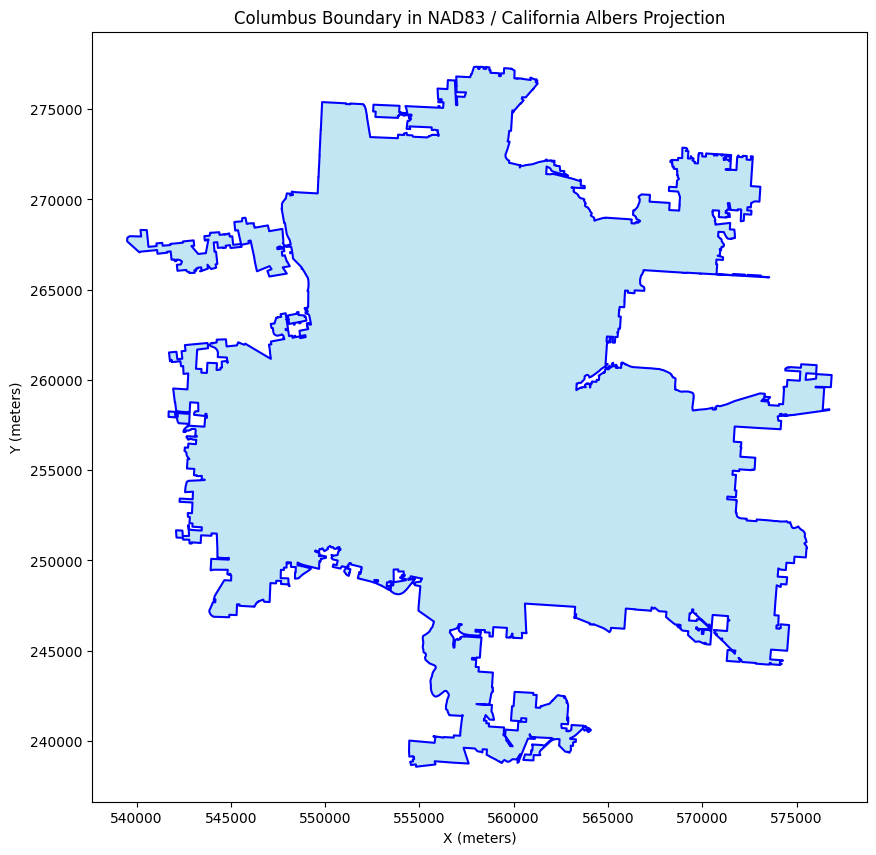

In [6]:
import json
import math
import matplotlib.pyplot as plt
# Step 4: Convert the coordinates of the polygon to NAD83 / California Albers projection (EPSG:3310)
columbus_bd = [convert_to_albers(lon, lat) for lon, lat in polygon]

# Plot
plt.figure(figsize=(10, 10))
xs, ys = zip(*columbus_bd)
plt.plot(xs, ys, 'b-')
plt.fill(xs, ys, 'skyblue', alpha=0.5)
plt.title('Columbus Boundary in NAD83 / California Albers Projection')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.show()

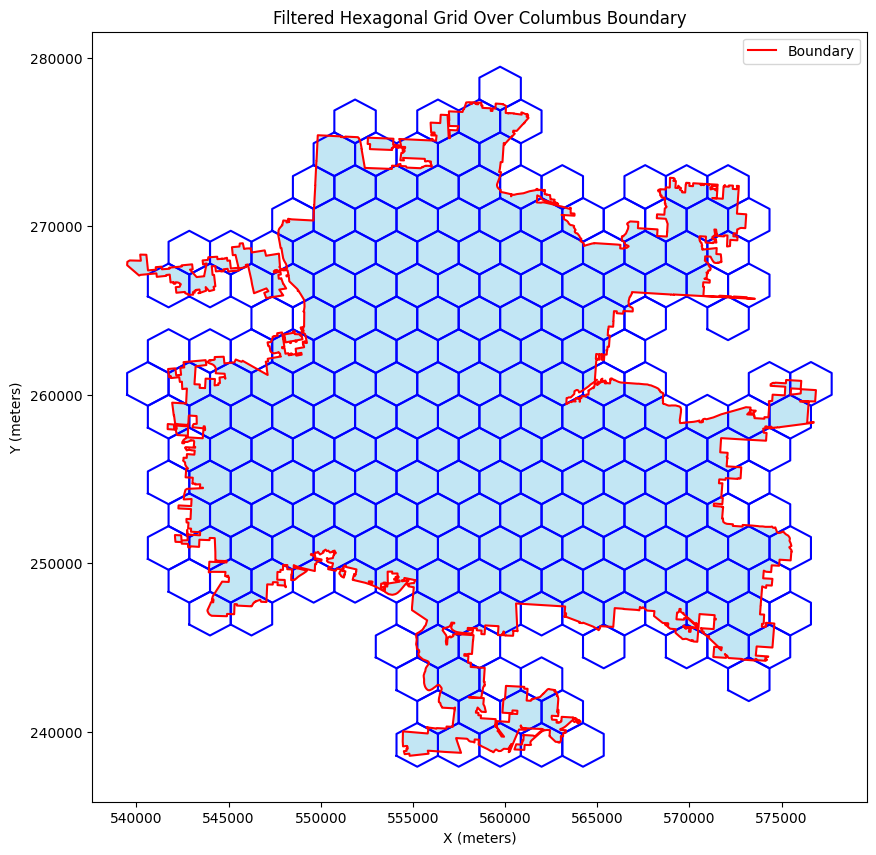

In [10]:
import json
import math
import matplotlib.pyplot as plt

columbus_bd = [convert_to_albers(lon, lat) for lon, lat in polygon]

# Step 4: Generate hexagonal grid over the boundary
def calculate_polygons(startx, starty, endx, endy, radius):
    sl = (2 * radius) * math.tan(math.pi / 6)
    p = sl * 0.5
    b = sl * math.cos(math.radians(30))
    w = b * 2
    h = 2 * sl

    startx = startx - w
    starty = starty - h
    endx = endx + w
    endy = endy + h

    origx = startx
    origy = starty

    xoffset = b
    yoffset = 3 * p

    polygons = []
    row = 1

    while starty < endy:
        if row % 2 == 0:
            startx = origx + xoffset
        else:
            startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty + p
            p2x = startx
            p2y = starty + (3 * p)
            p3x = startx + b
            p3y = starty + h
            p4x = startx + w
            p4y = starty + (3 * p)
            p5x = startx + w
            p5y = starty + p
            p6x = startx + b
            p6y = starty
            poly = [
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p5x, p5y),
                (p6x, p6y),
                (p1x, p1y)]
            polygons.append(poly)
            startx += w
        starty += yoffset
        row += 1
    return polygons

# Get the bounding box of the converted boundary
min_x = min(x for x, y in columbus_bd)
min_y = min(y for x, y in columbus_bd)
max_x = max(x for x, y in columbus_bd)
max_y = max(y for x, y in columbus_bd)

# Define the radius for the hexagons
hex_radius = mean_distance  # mean distance of trips

# Generate the hexagonal grid
hexagons = calculate_polygons(min_x, min_y, max_x, max_y, hex_radius)

# Function to check if a point is inside a polygon
def is_point_in_polygon(x, y, polygon):
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# Filter hexagons to keep only those that overlap with the boundary
columbus_hexagons = []
for hexagon in hexagons:
    for vertex in hexagon[:-1]:  # Check each vertex except the duplicate last one
        if is_point_in_polygon(vertex[0], vertex[1], columbus_bd):
            columbus_hexagons.append(hexagon)
            break

# Step 5: Plot the filtered hexagon grid and the boundary
plt.figure(figsize=(10, 10))
for hexagon in columbus_hexagons:
    xs, ys = zip(*hexagon)
    plt.plot(xs, ys, 'b-')

# Plot the boundary
bx, by = zip(*columbus_bd)
plt.plot(bx, by, 'r-', label='Boundary')
plt.fill(bx, by, 'skyblue', alpha=0.5)

plt.title('Filtered Hexagonal Grid Over Columbus Boundary')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.legend()
plt.show()


In [11]:
# Step 6: Store hexagons in a list of dictionaries
columbus_hexagons_data = []

for i, hexagon in enumerate(columbus_hexagons):
    columbus_hexagons_data.append({
        'hexagon_id': i,
        'polygon': hexagon
    })

# Display the first few hexagons
for hexagon in columbus_hexagons_data[:5]:
    print(hexagon)
    
print("There are", len(columbus_hexagons_data), "hexagon units over Columbus boundary.")

{'hexagon_id': 0, 'polygon': [(554111.0903855315, 238568.87207093835), (554111.0903855315, 239866.91274823467), (555235.2265872157, 240515.93308688284), (556359.3627888999, 239866.91274823467), (556359.3627888999, 238568.87207093835), (555235.2265872157, 237919.85173229018), (554111.0903855315, 238568.87207093835)]}
{'hexagon_id': 1, 'polygon': [(556359.3627888999, 238568.87207093835), (556359.3627888999, 239866.91274823467), (557483.498990584, 240515.93308688284), (558607.6351922683, 239866.91274823467), (558607.6351922683, 238568.87207093835), (557483.498990584, 237919.85173229018), (556359.3627888999, 238568.87207093835)]}
{'hexagon_id': 2, 'polygon': [(558607.6351922683, 238568.87207093835), (558607.6351922683, 239866.91274823467), (559731.7713939524, 240515.93308688284), (560855.9075956367, 239866.91274823467), (560855.9075956367, 238568.87207093835), (559731.7713939524, 237919.85173229018), (558607.6351922683, 238568.87207093835)]}
{'hexagon_id': 3, 'polygon': [(560855.9075956367